In [1]:
import pysal as ps
import hlm as hlm
import numpy as np
import pandas as pd
import scipy.linalg as scla
%load_ext rpy2.ipython

In [2]:
df = pd.read_csv('./test_data/test.csv')

In [3]:
W = ps.open('./test_data/w_lower.mtx').read()
M = ps.open('./test_data/w_upper.mtx').read()

In [4]:
membership = df.county.values - 1

In [5]:
Delta, mems = hlm.dong_harris.verify.Delta_members(Delta = None, membership=membership, 
                                     N=W.n, J=M.n)

In [6]:
np.testing.assert_allclose(mems, membership)

In [7]:
Delta

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [8]:
%Rpush Delta

In [9]:
df.head()

,id,u.full,y,x,county
0,0,-0.689048,0.788457,1,1
1,1,-0.689048,0.788457,0,1
2,2,-0.689048,1.064711,0,1
3,3,-0.689048,0.000000,0,1
4,4,-0.847313,1.131402,0,2


In [10]:
y = df[['y']].values
X = df[['x']].values

In [11]:
hlm.HSAR?

In [12]:
dh = hlm.HSAR(y, X, W, M, membership=membership, n_samples=0, spatial_method='met')

/home/ljw/dev/hlm/hlm/utils.py:141: ComplexWarning: Casting complex values to real discards the imaginary part
  emin = emin.astype(float)


In [13]:
st = dh.state

In [14]:
Betas, Thetas, Sigma2_e, Sigma2_u, Rho, Lambda = \
st.Betas, st.Thetas, st.Sigma2_e, st.Sigma2_u, st.Rho, st.Lambda

In [15]:
X, y = st.X, st.y

In [16]:
T0, M0, a0, b0, c0, d0, au, ce, Ij, In, M, W = \
st.T0, st.M0, st.a0, st.b0, st.c0, st.d0, st.au, st.ce, st.Ij, st.In, st.M, st.W

In [17]:
M = np.asarray(M.todense())
W = np.asarray(W.todense())

In [18]:
%Rpush y X Betas Thetas Sigma2_e Sigma2_u Rho Lambda
%Rpush T0 M0 a0 b0 c0 d0 au ce Ij In M W

### Beta Parameters

In [19]:
%%R
VV <- t(X) %*% X / Sigma2_e + solve(T0)
vBetas <- solve(VV)
print(vBetas)

             [,1]         [,2]
[1,]  0.002610830 -0.002610488
[2,] -0.002610488  0.015680334


In [20]:
Sigma_Betas = st.XtX / st.Sigma2_e + st.T0inv
Sigma_Betas = scla.inv(Sigma_Betas)

Sigma_Betas

array([[ 0.00261083, -0.00261049],
       [-0.00261049,  0.01568033]])

In [21]:
%%R
A <- In - Rho * W
Ay <- A %*% y
ZUs <- Delta %*% Thetas
mBetas <- vBetas %*% (t(X) %*% (Ay - ZUs) / Sigma2_e + solve(T0)%*%M0)
print(mBetas)

           [,1]
[1,]  0.7131099
[2,] -0.6323667


In [22]:
A = np.asarray(st.In - st.Rho * st.W)
Ay_DThetas = np.dot(A, st.y) - np.dot(st.Delta, st.Thetas)
mean_update = np.dot(st.X.T, Ay_DThetas) / st.Sigma2_e
Mu_Betas = np.dot(Sigma_Betas, mean_update + st.T0invM0)
print(Mu_Betas)

[[ 0.71310992]
 [-0.63236671]]


In [23]:
e = np.random.normal(0, 1, size=(2,1))
%Rpush e

In [24]:
%%R 
Betas <- mBetas + t(chol(vBetas)) %*% e
print(Betas)

           [,1]
[1,]  0.7944859
[2,] -0.5622076


In [25]:
Betas = Mu_Betas + np.dot(scla.cholesky(Sigma_Betas).T, e)
print(Betas)

[[ 0.79448589]
 [-0.56220761]]


### Theta Parameters

In [26]:
%%R
Z <- Delta
B <- Ij - Lambda * M
vU <- as.matrix(t(Z)%*%Z / Sigma2_e + t(B)%*%B/Sigma2_u)
vU <- solve(vU)
Xb <- X%*%Betas
mU <- vU %*% (as.numeric(t(Z)%*%(Ay - Xb))/ Sigma2_e)

In [27]:
%Rpull mU vU

In [28]:
B = np.asarray(Ij - Lambda * M)
BtB = np.dot(B.T, B)

Sigma_Thetas = st.DtD/Sigma2_e + BtB/Sigma2_u
Sigma_Thetas = scla.inv(Sigma_Thetas)

Ay_Xbetas = np.dot(A, st.y) - np.dot(st.X, Betas)
mean_kernel = np.dot(Delta.T, Ay_Xbetas) / Sigma2_e
Mu_Thetas = np.dot(Sigma_Thetas, mean_kernel)

In [29]:
np.allclose(vU, Sigma_Thetas)

True

In [30]:
np.allclose(mU, Mu_Thetas)

True

In [31]:
u = np.random.normal(0,1,size=(M.shape[0],1))
%Rpush u

In [32]:
%%R
cholV <- t(chol(vU))
Thetas <- mU + cholV%*%u

In [33]:
%Rpull Thetas
r_Thetas = Thetas

In [34]:
D = scla.cholesky(Sigma_Thetas)
kernel = np.dot(D.T, u)
Thetas = Mu_Thetas + kernel

In [35]:
np.allclose(Thetas, r_Thetas)

True

### Variance Parameters

In [36]:
deviations = Ay_Xbetas - np.dot(Delta, Thetas)
ssds = np.dot(deviations.T, deviations)
de = ssds*.5 + d0
print(ce,'\n', de)

459.51 
 [[ 353.46761554]]


In [37]:
%%R
Zu <- Z %*% Thetas
e <- Ay - Zu - Xb
de <- .5 * crossprod(e) + d0
print(ce)
print(de)

[1] 459.51
         [,1]
[1,] 353.4676


In [38]:
TtBtBT = np.dot(Thetas.T, np.dot(BtB, Thetas))
bu = TtBtBT/2 + b0
print(au,'\n',bu)

42.51 
 [[ 23.64295797]]


In [39]:
%%R
Bus <- B %*% Thetas
bu <- crossprod(Bus)/2 + b0
print(au)
print(bu)

[1] 42.51
         [,1]
[1,] 23.64296


### Rho

In [40]:
hlm.utils.speigen_range(W)

/home/ljw/dev/hlm/hlm/utils.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  emin, emax = eigs.min().astype(float), eigs.max().astype(float)


(-0.56223992222209485, 1.0000000000000109)

In [41]:
import scipy.sparse.linalg as spla
import scipy.sparse as sp
from hlm.dong_harris.sample import logp_kernel_rho, logp_kernel_lambda
from hlm.utils import splogdet

W_emin, W_emax = hlm.utils.speigen_range(W)
rhogrid = np.arange(1/W_emin, 1/W_emax, .01)[1:-1]

/home/ljw/dev/hlm/hlm/utils.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  emin, emax = eigs.min().astype(float), eigs.max().astype(float)


In [42]:
rhodets = [splogdet(sp.csc_matrix(In - rho * W)) for rho in rhogrid]

In [43]:
%Rpush rhogrid rhodets

In [44]:
%%R
Zu <- Delta %*% Thetas

In [45]:
%%R
beta0 <- solve(t(X) %*% X) %*% t(X) %*% y
e0 <- y - X %*% beta0
e0e0 <- crossprod(e0)


Wy <- as.numeric(W %*% y)

betad <- solve(t(X) %*% X) %*% t(X) %*% Wy
ed <- Wy - X %*% betad
eded <- crossprod(ed)

e0ed <- crossprod(e0, ed)

betau <- solve(t(X) %*% X) %*% t(X) %*% Zu
eu <- Zu - X%*%betau
eueu <- crossprod(eu)
e0eu <- crossprod(e0, eu)
edeu <- crossprod(ed,eu)

nrho <- length(rhogrid)
iota <- rep(1, times=nrho)

deviation <- A %*% y - X %*% Betas - Delta %*% Thetas
ssds <- t(deviation) %*% deviation / (2 * Sigma2_e)

S_rho <- e0e0*iota + rhogrid^2 * eded[1] + eueu[1] - 2*rhogrid*e0ed[1] - 2*e0eu[1] + 2*rhogrid*edeu[1]
log_den <- rhodets - S_rho / (2 * Sigma2_e)

In [46]:
%Rpull log_den ssds S_rho

In [47]:
ssds

array([[ 176.72880777]])

In [48]:
from hlm.dong_harris.sample import logp_kernel_rho, logp_kernel_lambda, logp_rho, logp_lambda

In [49]:
def kernel(Rho, W, In, X, Betas, Delta, Thetas, Sigma2_e):
    A = np.asarray(In - Rho * W)
    ssd = A @ y - X @ Betas - Delta @ Thetas
    return -1 * ssd.T @ ssd / (2. * Sigma2_e)

In [50]:
def dh_kernel(rhogrid, W, In, X, Betas, Delta, Thetas, Sigma2_e):
    XtXi = scla.inv(X.T @ X)
    
    beta0 = XtXi @ X.T @ y
    e0 = y - X @ beta0
    
    betad = XtXi @ X.T @ W @ y
    ed = W @ y - X @ betad
    
    betau = XtXi @ X.T @ Delta @ Thetas
    eu = Delta @ Thetas - X @ betau
    
    e0e0 = e0.T @ e0 
    e0ed = e0.T @ ed
    e0eu = e0.T @ eu
    eded = ed.T @ ed
    edeu = ed.T @ eu
    eueu = eu.T @ eu
    e0eu = e0.T @ eu
    
    iota = np.ones((rhogrid.shape))
    
    S = e0e0*iota + rhogrid**2 * eded + eueu - 2 * rhogrid * e0ed - 2 * e0eu + 2 * rhogrid * edeu 
    return -1 * S / (2 * Sigma2_e)

In [51]:
dhk = dh_kernel(rhogrid, W, In, X, Betas, Delta, Thetas, Sigma2_e)

In [52]:
_XtXi = scla.inv(X.T @ X)
%R XtXi <- solve(t(X) %*% X)

_beta0 = _XtXi @ X.T @ y
%R beta0 <- XtXi %*% t(X) %*% y

_e0 = y - X @ _beta0
%R e0 <- y - X %*% beta0

_betad = _XtXi @ X.T @ W @ y
%R betad <- XtXi %*% t(X) %*% W %*% y

_ed = W @ y - X @ _betad
%R ed <- W %*% y - X %*% betad

_betau = _XtXi @ X.T @ Delta @ Thetas
%R betau <- XtXi %*% t(X) %*% Delta %*% Thetas

_eu = Delta @ Thetas - X @ _betau
%R eu <- Delta %*% Thetas - X %*% betau

_e0e0 = _e0.T @ _e0 
%R e0e0 <- crossprod(e0)

_e0ed = _e0.T @ _ed
%R e0ed <- crossprod(e0,ed)

_eded = _ed.T @ _ed
%R eded <- crossprod(ed)

_edeu = _ed.T @ _eu
%R edeu <- crossprod(ed, eu)

_eueu = _eu.T @ _eu
%R eueu <- crossprod(eu)

_e0eu = _e0.T @ _eu
%R e0eu <- crossprod(e0, eu)

_iota = np.ones((rhogrid.shape))
%R iota <- rep(1, times=length(rhogrid))

_S = (_e0e0*_iota + rhogrid**2* _eded + _eueu 
      - 2*rhogrid*_e0ed -2*_e0eu + 2*rhogrid*_edeu )

In [53]:
%%R
S <- {e0e0*iota + rhogrid^2*as.numeric(eded) + as.numeric(eueu) - 2*rhogrid*as.numeric(e0ed) - 2*as.numeric(e0eu) + 2*rhogrid*as.numeric(edeu)}

In [54]:
%Rpull XtXi beta0 e0 e0e0 e0ed e0eu betad ed eded edeu betau eu eueu iota S

In [55]:
print('XtXi:\t', np.allclose(XtXi, _XtXi))
print('beta0:\t', np.allclose(beta0, _beta0))
print('betad:\t', np.allclose(betad, _betad))
print('betau:\t', np.allclose(betau, _betau))
print('e0:\t', np.allclose(e0, _e0))
print('e0e0:\t', np.allclose(e0e0, _e0e0))
print('e0eu:\t', np.allclose(e0eu, _e0eu))
print('e0ed:\t', np.allclose(e0ed, _e0ed))

print('ed:\t', np.allclose(ed, _ed))
print('eded:\t', np.allclose(eded, _eded))
print('edeu:\t', np.allclose(edeu, _edeu))

print('eu:\t', np.allclose(eu, _eu))
print('eueu:\t', np.allclose(eueu, _eueu))

print('iota:\t', np.allclose(iota, _iota))

print('S:\t', np.allclose(S, _S))

XtXi:	 True
beta0:	 True
betad:	 True
betau:	 True
e0:	 True
e0e0:	 True
e0eu:	 True
e0ed:	 True
ed:	 True
eded:	 True
edeu:	 True
eu:	 True
eueu:	 True
iota:	 True
S:	 True


In [56]:
def kernel(Rho, W, y, In, X, Betas, Delta, Thetas, Sigma2_e):
    """
    The kernel of the log likelihood in equation 31 of Dong & Harris (2014)
    """
    kern = (In - Rho * W) @ y - X @ Betas - Delta @ Thetas
    ssds = kern.T @ kern
    return -1 * ssds / (2 * Sigma2_e)

In [57]:
def logp(Rho, W, y, In, X, Betas, Delta, Thetas, Sigma2_e):
    """
    the full log likelihood of Rho in equation 31 of Dong & Harris (2014)
    """
    det = hlm.utils.splogdet(sp.csc_matrix(In - Rho * W))
    kern = kernel(Rho, W, In, X, Betas, Delta, Thetas, Sigma2_e)
    return det + kern

In [58]:
kernels = np.vstack([kernel(r, W, y, In, X, Betas, Delta, Thetas, Sigma2_e) 
                    for r in rhogrid]).flatten()

In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

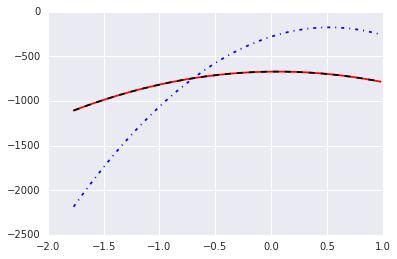

In [60]:
plt.plot(rhogrid, -1*S, 'r')
plt.plot(rhogrid, -1*_S.flatten(), 'k--')
plt.plot(rhogrid, kernels, 'b-.')
plt.show()

In [61]:
cm.summer(rhogrid)

array([[ 0.        ,  0.5       ,  0.4       ,  1.        ],
       [ 0.        ,  0.5       ,  0.4       ,  1.        ],
       [ 0.        ,  0.5       ,  0.4       ,  1.        ],
       ..., 
       [ 0.96470588,  0.98235294,  0.4       ,  1.        ],
       [ 0.97254902,  0.98627451,  0.4       ,  1.        ],
       [ 0.98431373,  0.99215686,  0.4       ,  1.        ]])

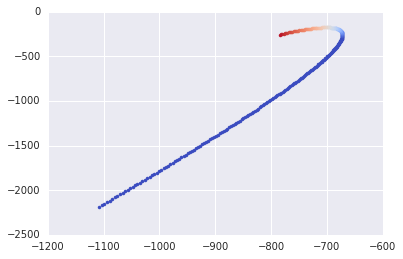

In [62]:
for r, py, color in zip(S, kernels, cm.coolwarm(rhogrid)):
    r = -1 * r
    plt.plot(r, py, color=color, marker='.')
plt.show()

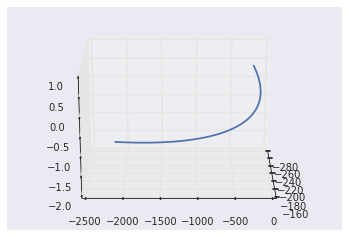

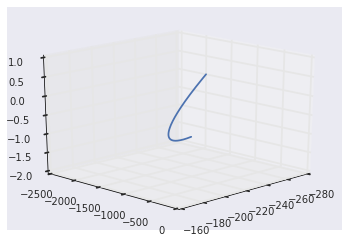

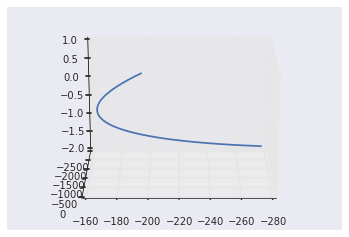

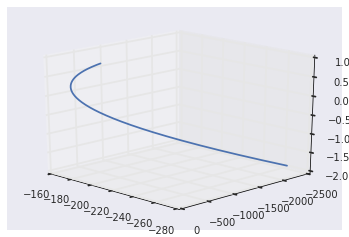

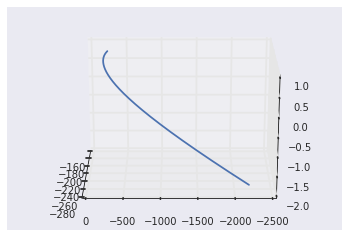

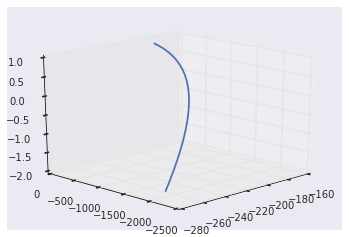

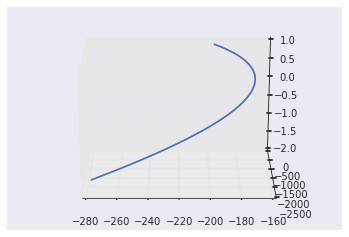

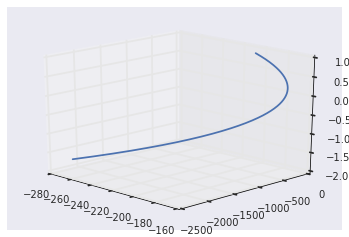

In [63]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

for angle in range(0,360,45):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    Y = np.asarray(kernels)
    X = -1*S/(2*Sigma2_e)
    Z = rhogrid
    surf = ax.plot3D(X, Y, Z)
    ax.view_init(20, angle)
    plt.show()

### Lambda

In [64]:
M_emin, M_emax = hlm.utils.speigen_range(M)
lambda_grid = np.arange(1./M_emin, 1./M_emax, .01)
lambda_dets = [splogdet(sp.csc_matrix(Ij - lam * M)) for lam in lambda_grid]

/home/ljw/dev/hlm/hlm/utils.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  emin, emax = eigs.min().astype(float), eigs.max().astype(float)


In [65]:
%Rpush lambda_grid lambda_dets

In [66]:
%%R
uu <- crossprod(Thetas)
uMu <- as.numeric(t(Thetas) %*% M %*% Thetas)
Mu <- as.numeric(M %*% Thetas)
uMMu <- crossprod(Mu)

nlambda <- length(lambda_grid)
iota <- rep(1, times=nlambda)

S_lambda <- uu*iota - 2*lambda_grid*uMu + lambda_grid^2*as.numeric(uMMu)

In [67]:
%Rpull S_lambda

In [68]:
uu = Thetas.T @ Thetas
uMu = Thetas.T @ M @ Thetas
Mu = M @ Thetas
uMMu = Mu.T @ Mu

iota = np.ones((len(lambda_grid), ))

S_lambda_py = uu * iota - 2 * lambda_grid * uMu + lambda_grid**2 * uMMu

In [69]:
kernel = lambda x: (Thetas.T @ (Ij - x * M).T @ (Ij - x * M) @ Thetas)

In [70]:
S_lambda_kernels = np.array([kernel(lam) for lam in lambda_grid]).flatten()

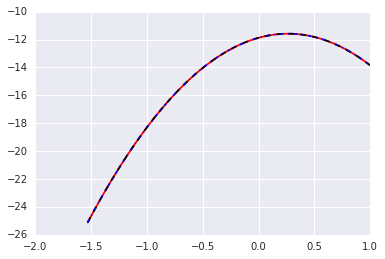

In [71]:
plt.plot(lambda_grid, -1/(2*Sigma2_e)*S_lambda, 'r')
plt.plot(lambda_grid, -1/(2*Sigma2_e)*S_lambda_py.flatten(), 'k--')
plt.plot(lambda_grid, -1/(2*Sigma2_e)*S_lambda_kernels, 'b-.')
plt.show()